In [31]:
# Environment and API access
from dotenv import load_dotenv  # Loads environment variables from a .env file
import openai                   # OpenAI API client (used for calling GPT models)

# Data manipulation and analysis
import pandas as pd             
import numpy as np              
from sklearn.cluster import KMeans  # Clustering algorithm 

# File and system utilities
import os                       # Interacting with the operating system (e.g., paths, env vars)
import json                     # Reading/writing JSON files
import random                   # Random number generation (e.g., sampling, shuffling)

# Image processing and visualization
import cv2                      # OpenCV for image manipulation and computer vision tasks
from matplotlib import pyplot as plt  


In [32]:
from dotenv import load_dotenv
load_dotenv()


True

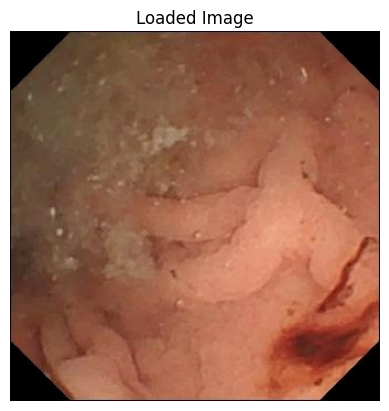

In [33]:
finding_category = "Luminal"
finding_class = "Angiectasia"

# Load the image in color (BGR format)
img = cv2.imread(r'kvasir-capsule/angiectasia/04a78ef00c5245e0_11603.jpg')

# Convert BGR to RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Loaded Image')
plt.show()


In [34]:
img_rgb.shape

(336, 336, 3)

In [35]:
# colour analysis of current image - provide list of dominant colours
def dominant_colours(img_rgb):

    colours = []

import cv2


def extract_dominant_colors(image: np.ndarray, num_colors: int = 5):
    """
    Extracts dominant colors from an RGB image using KMeans clustering.
    
    Args:
        image (np.ndarray): RGB image as a NumPy array.
        num_colors (int): Number of dominant colors to extract.
    
    Returns:
        List of tuples: Each tuple contains (RGB, HEX) representation.
    """
    # Reshape image to a 2D array of pixels
    pixels = image.reshape(-1, 3)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)

    # Get cluster centers (dominant colors)
    centers = kmeans.cluster_centers_.astype(int)

    # Convert to HEX
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(*rgb)

    return [(tuple(center), rgb_to_hex(center)) for center in centers]


extract_dominant_colors(img_rgb, 5)

[((140, 86, 63), '#8c563f'),
 ((109, 70, 51), '#6d4633'),
 ((5, 0, 0), '#050000'),
 ((209, 133, 104), '#d18568'),
 ((174, 106, 79), '#ae6a4f')]

In [36]:
def describe_bounding_box(box, image_width, image_height):
    """
    Describe a bounding box in terms of relative size and centroid location.
    
    Parameters:
        box: tuple (x_min, y_min, x_max, y_max)
        image_width: int
        image_height: int
        
    Returns:
        str: Human-readable description of the bounding box
    """
    x_min, y_min, x_max, y_max = box
    box_area = (x_max - x_min) * (y_max - y_min)
    image_area = image_width * image_height
    rel_area = box_area / image_area

    # Size category
    if rel_area < 0.20:
        size = "small"
    elif rel_area < 0.40:
        size = "reasonably small"
    elif rel_area < 0.60:
        size = "medium"
    elif rel_area < 0.80:
        size = "large"
    else:
        size = "dominant"

    # Centroid
    cx = (x_min + x_max) / 2 / image_width
    cy = (y_min + y_max) / 2 / image_height

    # Horizontal position
    if cx < 0.33:
        horiz = "left"
    elif cx < 0.66:
        horiz = "middle"
    else:
        horiz = "right"

    # Vertical position
    if cy < 0.33:
        vert = "upper"
    elif cy < 0.66:
        vert = "middle"
    else:
        vert = "lower"

    return f"The object occupies a {size} portion of this image, centered in the {vert}-{horiz} region."

box = (222,332,334,222)
bbox = describe_bounding_box(box, 336, 336)
bbox

'The object occupies a small portion of this image, centered in the lower-right region.'

In [37]:
# Simulated input for one endoscopy frame
sample_frame = {
    "finding_category": finding_category,
    "finding_class": finding_class,
    "compartment_probs": {
        "1_esophagus": 0.02,
        "2_stomach": 0.14,
        "3_small_bowel": 0.14,
        "4_colon": 0.7
    },
    "bubbles_present": 1,
    "blurred_image": 0,
    "bounding_box": bbox,
    "description": "a small, red substance with a small, red substance on the surface" # from BLIP
}

def get_most_likely_compartment(probs, threshold=0.5):
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    top_compartment, confidence = sorted_probs[0]
    if confidence < threshold:
        return f"Uncertain compartment (likely {top_compartment.split('_')[1]} with {confidence:.2f} confidence)"
    return top_compartment.split('_')[1]

def synthesize_caption(frame):
    compartment = get_most_likely_compartment(frame["compartment_probs"])
    bubbles = "bubbles present" if frame["bubbles_present"] else "no bubbles"
    blur = "blurred" if frame["blurred_image"] else "sharp"
    
    # Optional: flag odd BLIP captions
    blip_flag = ""
    if "rock" in frame["description"] or "mouth" in frame["description"]:
        blip_flag = "⚠️ BLIP caption may be off-topic"

    caption = (
        f"{frame['finding_class']} ({frame['finding_category']}) "
        f"in the {compartment}. "
        f"Image is {blur}, with {bubbles}. "
        f"Of particular interest in this frame is {bbox}. "
        f"description: \"{frame['description']}\". "
    )
    return caption

# Run test
print("🩺 Synthesized Caption:")
caption = synthesize_caption(sample_frame)
print(caption)


🩺 Synthesized Caption:
Angiectasia (Luminal) in the colon. Image is sharp, with bubbles present. Of particular interest in this frame is The object occupies a small portion of this image, centered in the lower-right region.. description: "a small, red substance with a small, red substance on the surface". 


In [38]:
load_dotenv()

openai.api_key = os.getenv("llm_example_key")

def analyze_text(text):
    prompt = f"""
You are an experienced diagnostic gastroenterologist analyzing a still from a wireless capsule endoscopy (WCE) video. 

Auxiliary evidence provided:
1. The following description was generated by a general-purpose vision model.  
This model is not trained on medical data and may only provide rough, general observations.  
Treat this description as low-confidence and use it only for superficial description:   
   \"\"\"{text}\"\"\"

2. Colour spectrum analysis of current frame:  
   Dominant colour buckets → ["deep red", "light pink", "pale yellow"]  
   Relative proportions → ["deep red = high", "light pink = moderate", "pale yellow = low"]

3. Temporal colour consistency (N frames before/after):  
   - Preceding frames: ["pale pink", "pale yellow", low saturation"]  
   - Current frame: ["deep red dominates"]  
   - Following frames: ["pale pink", "pale yellow", low saturation"]

Task: Using (a) your own WCE medical image reasoning primarily,  
(b) the colour spectrum patterns, and  
(c) the description only if superficially relevant.
Describe  in medically appropriate English what is most likely happening in this frame, possible anatomical region,  
and any abnormalities or clinical concerns as though talking to a surgical team.
Highlight uncertainty clearly.

"""
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5
    )
    return response['choices'][0]['message']['content']

print(analyze_text(caption))

In this particular frame of the wireless capsule endoscopy (WCE) video, the dominant color is deep red, indicating the presence of angiectasia in the colon. Angiectasia refers to small, vascular lesions in the gastrointestinal tract that can cause gastrointestinal bleeding. The description provided by the vision model also mentions a small, red substance with a small, red substance on the surface, which aligns with the presence of angiectasia.

Given the location of the object in the lower-right region of the image, it is likely that the angiectasia is localized to a specific area of the colon. This finding is concerning as angiectasia can lead to gastrointestinal bleeding, which may require intervention to manage.

The temporal color consistency analysis shows a shift from pale pink and pale yellow in the preceding and following frames to deep red dominance in the current frame. This change in color spectrum further supports the presence of angiectasia and the associated bleeding in t

In [39]:


def explain_to_patient(text):
    prompt = f"""
You are an experienced diagnostic gastroenterologist analyzing a still from a wireless capsule endoscopy (WCE) video. 

Auxiliary evidence provided:
1. The following description was generated by a general-purpose vision model.  
This model is not trained on medical data and may only provide rough, general observations.  
Treat this description as low-confidence and use it only for superficial description:   
   \"\"\"{text}\"\"\"

2. Colour spectrum analysis of current frame:  
   Dominant colour buckets → ["deep red", "light pink", "pale yellow"]  
   Relative proportions → ["deep red = high", "light pink = moderate", "pale yellow = low"]

3. Temporal colour consistency (N frames before/after):  
   - Preceding frames: ["pale pink", "pale yellow", low saturation"]  
   - Current frame: ["deep red dominates"]  
   - Following frames: ["pale pink", "pale yellow", low saturation"]

Task: Using (a) your own WCE medical image reasoning primarily,  
(b) the colour spectrum patterns, and  
(c) the description only if superficially relevant.
Explain what you see in the image to a non-medical but university educated patient and their family.  Use appropriate high level medical
terminology explaining what that means but do not be overwhelming.  Explain compassionately, giving early indications as to whether
it is to be concerned about, or that it's something that is relatively benign.
Highlight uncertainty clearly.

"""
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.5
    )
    return response['choices'][0]['message']['content']

print(explain_to_patient(caption))

In the image from the wireless capsule endoscopy video, we can see a small, red object in the lower-right region of the colon. This object appears to be angiectasia, which is a term used to describe a small blood vessel abnormality in the lining of the colon. The dominant colors in the image are deep red, light pink, and pale yellow.

Angiectasia in the colon can sometimes cause bleeding, which may present as bright red blood in the stool. However, it is important to note that the presence of angiectasia does not always indicate a serious issue. In some cases, angiectasia can be a benign finding that does not require immediate intervention.

Based on the information provided, there is some uncertainty regarding the significance of the angiectasia seen in the image. It is essential for further evaluation by a gastroenterologist to determine the cause of the angiectasia and whether any treatment is necessary. If there are any concerning symptoms such as ongoing bleeding or abdominal pain